# Tutorial

Make sure that you have done a [proper installation of pysrim and SRIM](https://pysrim.readthedocs.io/en/latest/installation.html)

In this tutorial we will cover:
  - running a TRIM calcualtion
  - running a SR calculation
  - analyzing TRIM calculation output files
  
Most emphasis will be put on what is possible for analysis of SRIM calcualtions.

We will assume **python3** for this notebook.

In [1]:
%matplotlib inline

import os
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt

from srim.srim import TRIM, SR
from srim.core.target import Target
from srim.core.layer import Layer
from srim.core.ion import Ion
from srim.output import (
    Results, Phonons, Ioniz, Vacancy, 
    NoVacancy, EnergyToRecoils, Range
)

In [3]:
def plot_damage_energy(folder, ax):
    phon = Phonons(folder)
    dx = max(phon.depth) / 100.0 # to units of Angstroms
    energy_damage = (phon.ions + phon.recoils) * dx
    ax.plot(phon.depth, energy_damage / phon.num_ions, label='{}'.format(folder))
    return sum(energy_damage)

def plot_ionization(folder, ax):
    ioniz = Ioniz(folder)
    dx = max(ioniz.depth) / 100.0 # to units of Angstroms
    ax.plot(ioniz.depth, ioniz.ions, label='Ionization from Ions')
    ax.plot(ioniz.depth, ioniz.recoils, label='Ionization from Recoils')
    
def plot_vacancies(folder, ax):
    vac = Vacancy(folder)
    vacancy_depth = vac.knock_ons + np.sum(vac.vacancies, axis=1)
    ax.plot(vac.depth, vacancy_depth, label="Total vacancies at depth")
    return sum(vacancy_depth)

# Run a SRIM Calculation

Running a srim calculation is much like the gui that SRIM provides.

Concepts:
  - a list of Layers forms a Target
  - a Layer is a dict of elements, with density, and a width
  - an Element can be specified by symbol, atomic number, or name, with a custom mass [amu]
  - an Ion is like an Element except that it also requires an energy in [eV]

In [6]:
# Construct a 3MeV Nickel ion
ion = Ion('Ni', energy=3.0e6)

# Construct a layer of nick 20um thick with a displacement energy of 30 eV
layer = Layer({
        'Ni': {
            'stoich': 1.0, 
            'E_d': 30.0, 
            'lattice': 0.0, 
            'surface': 3.0
        }}, density=8.9, width=20000.0)

# Construct a target of a single layer of Nickel
target = Target([layer])

# Initialize a TRIM calculation with given target and ion for 25 ions, quick calculation
trim = TRIM(target, ion, number_ions=25, calculation=1)

# Specify the directory of SRIM.exe
# For windows users the path will include C://...
srim_executable_directory = '/tmp/srim' 

# takes about 10 seconds on my laptop
results = trim.run(srim_executable_directory)
# If all went successfull you should have seen a TRIM window popup and run 25 ions!

The results variable contains dictionary of automatically parsed TRIM output files.

If you needed to get the results later. Suppose you no longer had the results variable.
The results from the calculation were written to the `srim_executable_directory`, `/tmp/srim` in this case.

In [7]:
# equivalent to results variable gotten from `trim.run`
srim_executable_directory = '/tmp/srim' 
results = Results(srim_executable_directory)

In [8]:
print('Number of Ions: {}'.format(results.ioniz.num_ions))
results.__dict__

Number of Ions: 25


{'ioniz': <srim.output.Ioniz at 0x7f0510b3cb38>,
 'vacancy': <srim.output.Vacancy at 0x7f0510b3c390>,
 'novac': None,
 'etorecoils': <srim.output.EnergyToRecoils at 0x7f0510b3c128>,
 'phonons': <srim.output.Phonons at 0x7f0510b3c320>,
 'range': <srim.output.Range at 0x7f0510b3ca20>}

# Copy SRIM files
Helper function to copy SRIM files from one directory to another. Covers all of the output files.

In [15]:
output_directory = '/tmp/srim_outputs'
os.makedirs(output_directory, exist_ok=True)
print('Before:', os.listdir(output_directory))
TRIM.copy_output_files('/tmp/srim', output_directory)
print('After:', os.listdir(output_directory))

Before: []
After: ['TRIM.IN', 'LATERAL.txt', 'NOVAC.txt', 'E2RECOIL.txt', 'VACANCY.txt', 'RANGE.txt', 'IONIZ.txt', 'PHONON.txt']


# Run a SR Calculation 

In [17]:
# Run a SR calculation
ion = Ion('Ni', energy=3.0e6)
layer = Layer({
        'Ni': {
            'stoich': 1.0, 
            'E_d': 30.0, 
            'lattice': 0.0, 
            'surface': 3.0
        }}, density=8.9, width=20000.0)
sr = SR(layer, ion)
sr.run('/tmp/srim')

# Problem 1
Calculate the damage energy

In [26]:
# We will be using provided test_files

folders = ['../../test_files/2', '../../test_files/4']

Damage energy: 581927.2937478882 eV
Damage energy: 1415598.3836889009 eV


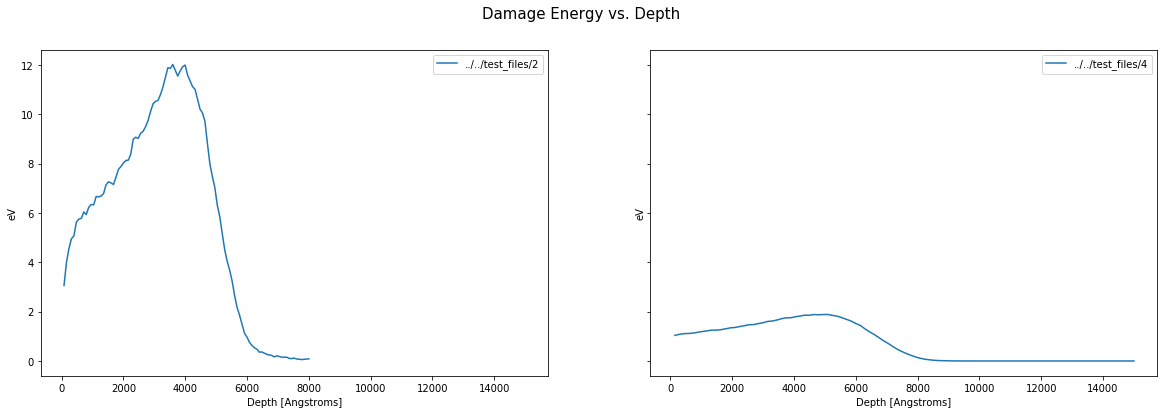

In [43]:
fig, axes = plt.subplots(1, len(folders), sharex=True, sharey=True)

for ax, folder in zip(np.ravel(axes), folders):
    energy_damage = plot_damage_energy(folder, ax)
    print("Damage energy: {} eV".format(energy_damage))
    ax.set_xlabel('Depth [Angstroms]')
    ax.set_ylabel('eV')
    ax.legend()

fig.suptitle('Damage Energy vs. Depth', fontsize=15)
fig.set_size_inches((20, 6))

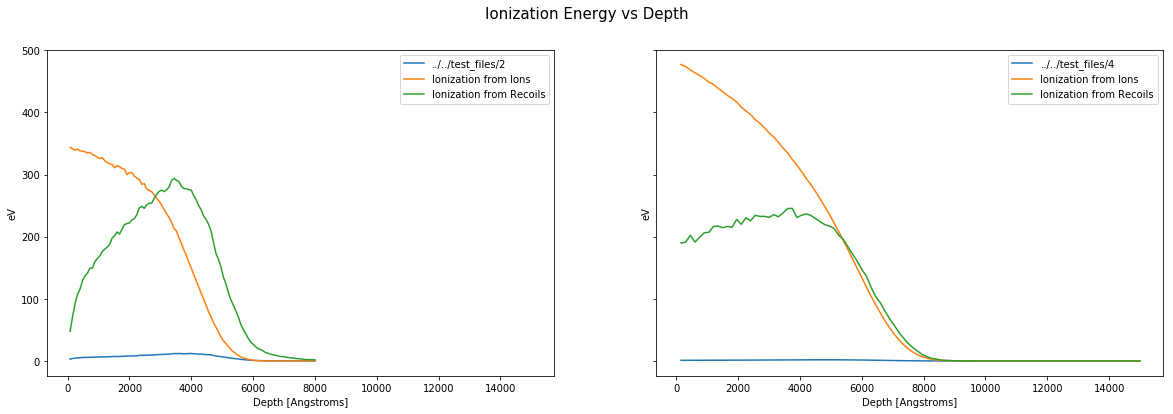

In [38]:
fig, axes = plt.subplots(1, len(folders), sharey=True, sharex=True)

for ax, folder in zip(np.ravel(axes), folders):
    plot_damage_energy(folder, ax)
    plot_ionization(folder, ax)
    ax.legend()
    ax.set_ylabel('eV')
    ax.set_xlabel('Depth [Angstroms]')
fig.suptitle('Ionization Energy vs Depth', fontsize=15)
fig.set_size_inches((20, 6))

Total number of vacancies ../../test_files/2: 253.08044912900002
Total number of vacancies ../../test_files/4: 114.54395856759996


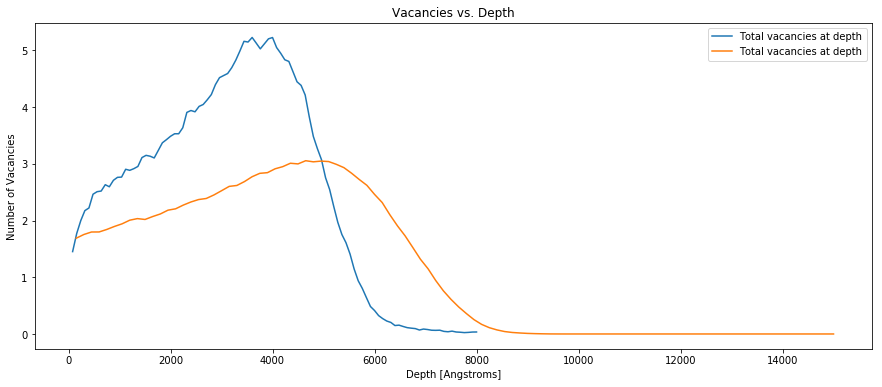

In [45]:
fig, ax = plt.subplots()

for i, folder in enumerate(folders):
    total_vacancies = plot_vacancies(folder, ax)
    print("Total number of vacancies {}: {}".format(folder, total_vacancies))

ax.set_xlabel('Depth [Angstroms]')
ax.set_ylabel('Number of Vacancies')
ax.set_title('Vacancies vs. Depth')
ax.legend()
fig.set_size_inches((15, 6))